![FS_Slide](img/HPCP_FS/Folie1.PNG)

![FS_Slide](img/HPCP_FS/Folie2.PNG)

![FS_Slide](img/HPCP_FS/Folie3.PNG)

![FS_Slide](img/HPCP_FS/Folie4.PNG)

![FS_Slide](img/HPCP_FS/Folie5.PNG)

![Kernel](img/Linux-storage-stack-diagram_v6.16.png) 

### Case Study: Optimizing File Access Patterns (FITS vs. Sorted vs. HDF5)

Background: The Euclid space telescope (ESA mission) produces large images of the sky. Imagine a single, very large FITS file that packs numerous galaxies spread across multiple HDUs (Header/Data Units). In our case, each image is segmented into a 6×6 grid of detectors, and each detector is further split into 4 quadrants, yielding 36 × 4 = 144 HDUs/headers per image. FITS (Flexible Image Transport System) is a classic astrophysics file format: it stores data (images, tables) with text headers describing them. A FITS file might contain one primary image and many extension images; each extension has a 2880-byte aligned header and then data. The Euclid processing code needs to extract and process millions of galaxies stored in these files. Our code is extracting galaxy stamps - small cut-out images - of each galaxy for further processing.

**Problem**: Accessing those stamps in the naive way

* Seek to its location in the FITS file (which might be a random position if stamps are scattered).
* Read the small chunk of bytes that make up that stamp (maybe each stamp is, say, 100×100 pixels – about 10,000 elements, which at 4 bytes each is 40 KB).
* Move on to the next stamp.

If the stamps are not in file order, this results in random reads all over a very large file. Each small read will likely trigger the filesystem to load a full block (e.g., 4 MB) from disk, of which only 40 KB are used – the rest is “wasted” overhead. Also, each access may require re-reading FITS headers or jumping to different extensions, incurring extra overhead in the FITS library (parsing the header). In short, the pattern is: open file, seek, read 40 KB, seek somewhere far, read 40 KB, … repeated thousands of times.


In [3]:
from pathlib import Path
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import KDTree
import time
import os

import json

from stampextraction.vis_exposures import VisExposureFitsIO, VisExposureHDF5
from stampextraction.stamps import extract_exposure_stamp

In [4]:
#Define files
datafiles = {}
datafiles["DET"] = "EUC_SHE_VIS-DET-1-1_0_20250701T085217.429173Z_09.10.fits"
datafiles["BKG"] = "EUC_SHE_VIS-BKG-1-1_0_20250701T085217.429307Z_09.10.fits"
datafiles["WGT"] = "EUC_SHE_VIS-WGT-1-1_0_20250701T085217.429294Z_09.10.fits"
datafiles["SEG"] = "EUC_SHE_EXP-RPJ-SEG_00_20250701T085301.676748Z_09.10.fits"
datafiles["MER"] = "EUC_SHE_MER-CAT_00_20250701T085255.628039Z_09.10.fits"
datafiles["HDF5"] = "image_data.hdf5"
datapath = Path("/shared-scratch/hpcp/data")

#### The Euclid data set
The Euclid Catalog FITS file contains about 144,000 galaxy objects in this simulated image, each with many recorded properties.  
For this example, we are only interested in three fields:  

- `OBJECT_ID`  
- `RIGHT_ASCENSION`  
- `DECLINATION`  

Let’s open the catalog and take a first look.

In [8]:
from astropy.table import Table
mer_table = Table.read(datapath / datafiles["MER"], memmap=False)
mer_table[0:10]

OBJECT_ID,RIGHT_ASCENSION,DECLINATION,SEGMENTATION_MAP_ID,VIS_DET,FLUX_G_EXT_DECAM_APER,FLUX_R_EXT_DECAM_APER,FLUX_I_EXT_DECAM_APER,FLUX_Z_EXT_DECAM_APER,FLUX_U_EXT_OMEGACAM_APER,FLUX_G_EXT_OMEGACAM_APER,FLUX_R_EXT_OMEGACAM_APER,FLUX_I_EXT_OMEGACAM_APER,FLUX_U_EXT_LSST_APER,FLUX_G_EXT_LSST_APER,FLUX_R_EXT_LSST_APER,FLUX_I_EXT_LSST_APER,FLUX_Z_EXT_LSST_APER,FLUX_U_EXT_MEGACAM_APER,FLUX_R_EXT_MEGACAM_APER,FLUX_G_EXT_JPCAM_APER,FLUX_I_EXT_PANSTARRS_APER,FLUX_Z_EXT_PANSTARRS_APER,FLUX_Z_EXT_HSC_APER,FLUX_G_EXT_HSC_APER,FLUX_VIS_APER,FLUX_Y_APER,FLUX_J_APER,FLUX_H_APER,FLUXERR_G_EXT_DECAM_APER,FLUXERR_R_EXT_DECAM_APER,FLUXERR_I_EXT_DECAM_APER,FLUXERR_Z_EXT_DECAM_APER,FLUXERR_U_EXT_OMEGACAM_APER,FLUXERR_G_EXT_OMEGACAM_APER,FLUXERR_R_EXT_OMEGACAM_APER,FLUXERR_I_EXT_OMEGACAM_APER,FLUXERR_U_EXT_LSST_APER,FLUXERR_G_EXT_LSST_APER,FLUXERR_R_EXT_LSST_APER,FLUXERR_I_EXT_LSST_APER,FLUXERR_Z_EXT_LSST_APER,FLUXERR_U_EXT_MEGACAM_APER,FLUXERR_R_EXT_MEGACAM_APER,FLUXERR_G_EXT_JPCAM_APER,FLUXERR_I_EXT_PANSTARRS_APER,FLUXERR_Z_EXT_PANSTARRS_APER,FLUXERR_Z_EXT_HSC_APER,FLUXERR_G_EXT_HSC_APER,FLUXERR_VIS_APER,FLUXERR_Y_APER,FLUXERR_J_APER,FLUXERR_H_APER,FLUX_NIR_STACK_APER,FLUXERR_NIR_STACK_APER,FLUX_G_EXT_DECAM_TOTAL,FLUX_R_EXT_DECAM_TOTAL,FLUX_I_EXT_DECAM_TOTAL,FLUX_Z_EXT_DECAM_TOTAL,FLUX_U_EXT_OMEGACAM_TOTAL,FLUX_G_EXT_OMEGACAM_TOTAL,FLUX_R_EXT_OMEGACAM_TOTAL,FLUX_I_EXT_OMEGACAM_TOTAL,FLUX_U_EXT_LSST_TOTAL,FLUX_G_EXT_LSST_TOTAL,FLUX_R_EXT_LSST_TOTAL,FLUX_I_EXT_LSST_TOTAL,FLUX_Z_EXT_LSST_TOTAL,FLUX_U_EXT_MEGACAM_TOTAL,FLUX_R_EXT_MEGACAM_TOTAL,FLUX_G_EXT_JPCAM_TOTAL,FLUX_I_EXT_PANSTARRS_TOTAL,FLUX_Z_EXT_PANSTARRS_TOTAL,FLUX_Z_EXT_HSC_TOTAL,FLUX_G_EXT_HSC_TOTAL,FLUX_Y_TOTAL,FLUX_J_TOTAL,FLUX_H_TOTAL,FLUXERR_G_EXT_DECAM_TOTAL,FLUXERR_R_EXT_DECAM_TOTAL,FLUXERR_I_EXT_DECAM_TOTAL,FLUXERR_Z_EXT_DECAM_TOTAL,FLUXERR_U_EXT_OMEGACAM_TOTAL,FLUXERR_G_EXT_OMEGACAM_TOTAL,FLUXERR_R_EXT_OMEGACAM_TOTAL,FLUXERR_I_EXT_OMEGACAM_TOTAL,FLUXERR_U_EXT_LSST_TOTAL,FLUXERR_G_EXT_LSST_TOTAL,FLUXERR_R_EXT_LSST_TOTAL,FLUXERR_I_EXT_LSST_TOTAL,FLUXERR_Z_EXT_LSST_TOTAL,FLUXERR_U_EXT_MEGACAM_TOTAL,FLUXERR_R_EXT_MEGACAM_TOTAL,FLUXERR_G_EXT_JPCAM_TOTAL,FLUXERR_I_EXT_PANSTARRS_TOTAL,FLUXERR_Z_EXT_PANSTARRS_TOTAL,FLUXERR_Z_EXT_HSC_TOTAL,FLUXERR_G_EXT_HSC_TOTAL,FLUXERR_Y_TOTAL,FLUXERR_J_TOTAL,FLUXERR_H_TOTAL,FLUX_VIS_PSF,FLUXERR_VIS_PSF,FLUX_SEGMENTATION,FLUXERR_SEGMENTATION,FLUX_DETECTION_TOTAL,FLUXERR_DETECTION_TOTAL,FLAG_G_EXT_DECAM,FLAG_R_EXT_DECAM,FLAG_I_EXT_DECAM,FLAG_Z_EXT_DECAM,FLAG_U_EXT_OMEGACAM,FLAG_G_EXT_OMEGACAM,FLAG_R_EXT_OMEGACAM,FLAG_I_EXT_OMEGACAM,FLAG_U_EXT_LSST,FLAG_G_EXT_LSST,FLAG_R_EXT_LSST,FLAG_I_EXT_LSST,FLAG_Z_EXT_LSST,FLAG_U_EXT_MEGACAM,FLAG_R_EXT_MEGACAM,FLAG_G_EXT_JPCAM,FLAG_I_EXT_PANSTARRS,FLAG_Z_EXT_PANSTARRS,FLAG_Z_EXT_HSC,FLAG_G_EXT_HSC,FLAG_VIS,FLAG_Y,FLAG_J,FLAG_H,FLAG_NIR_STACK,AVG_TRANS_WAVE_G_EXT_DECAM,AVG_TRANS_WAVE_R_EXT_DECAM,AVG_TRANS_WAVE_I_EXT_DECAM,AVG_TRANS_WAVE_Z_EXT_DECAM,AVG_TRANS_WAVE_U_EXT_OMEGACAM,AVG_TRANS_WAVE_G_EXT_OMEGACAM,AVG_TRANS_WAVE_R_EXT_OMEGACAM,AVG_TRANS_WAVE_I_EXT_OMEGACAM,AVG_TRANS_WAVE_U_EXT_LSST,AVG_TRANS_WAVE_G_EXT_LSST,AVG_TRANS_WAVE_R_EXT_LSST,AVG_TRANS_WAVE_I_EXT_LSST,AVG_TRANS_WAVE_Z_EXT_LSST,AVG_TRANS_WAVE_U_EXT_MEGACAM,AVG_TRANS_WAVE_R_EXT_MEGACAM,AVG_TRANS_WAVE_G_EXT_JPCAM,AVG_TRANS_WAVE_I_EXT_PANSTARRS,AVG_TRANS_WAVE_Z_EXT_PANSTARRS,AVG_TRANS_WAVE_Z_EXT_HSC,AVG_TRANS_WAVE_G_EXT_HSC,AVG_TRANS_WAVE_VIS,AVG_TRANS_WAVE_Y,AVG_TRANS_WAVE_J,AVG_TRANS_WAVE_H,DEBLENDED_FLAG,PARENT_ID,PARENT_VISNIR,BLENDED_PROB,SHE_FLAG,VARIABLE_FLAG,BINARY_FLAG,POINT_LIKE_FLAG,POINT_LIKE_PROB,EXTENDED_FLAG,EXTENDED_PROB,SPURIOUS_FLAG,SPURIOUS_PROB,MAG_STARGAL_SEP,DET_QUALITY_FLAG,MU_MAX,MUMAX_MINUS_MAG,SEGMENTATION_AREA,A_IMAGE,POSITION_ANGLE,ELLIPTICITY,CONCENTRATION,ASYMMETRY,SMOOTHNESS,GINI,MOMENT_20,A_IMAGE_ERR,POSITION_ANGLE_ERR,ELLIPTICITY_ERR,CONCENTRATION_ERR,ASYMMETRY_ERR,SMOOTHNESS_ERR,GINI_ERR,MOMENT_20_ERR,GAL_EBV,GAL_EBV_ERR
int64,float64,float64,int64,int16,float32,float32,float32,float32,float32,float32,float32,float32,float

Lets have a look at the detector file. A Fits file with 3 extensions for each quadrant. We have a grid of 6x6 CCDs, each consists of 4 quadrants. So the FITS file contains 432 HDUs:
*  SCI: VIS science imag
*  RMS: quadrant readout noise
*  FLG: quality-control image 

In [5]:
hdu_list = fits.open(datapath / datafiles["DET"])
hdu_list.info()

Filename: /shared-scratch/hpcp/data/EUC_SHE_VIS-DET-1-1_0_20250701T085217.429173Z_09.10.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     192   ()      
  1  1-1.E.SCI     1 ImageHDU        65   (2048, 2048)   float32   
  2  1-1.E.RMS     1 ImageHDU        65   (2048, 2048)   float32   
  3  1-1.E.FLG     1 ImageHDU        65   (2048, 2048)   int32   
  4  1-1.F.SCI     1 ImageHDU        65   (2048, 2048)   float32   
  5  1-1.F.RMS     1 ImageHDU        65   (2048, 2048)   float32   
  6  1-1.F.FLG     1 ImageHDU        65   (2048, 2048)   int32   
  7  1-1.G.SCI     1 ImageHDU        65   (2048, 2048)   float32   
  8  1-1.G.RMS     1 ImageHDU        65   (2048, 2048)   float32   
  9  1-1.G.FLG     1 ImageHDU        65   (2048, 2048)   int32   
 10  1-1.H.SCI     1 ImageHDU        65   (2048, 2048)   float32   
 11  1-1.H.RMS     1 ImageHDU        65   (2048, 2048)   float32   
 12  1-1.H.FLG     1 ImageHDU        65   (2048, 204

Let us have a closer look at a single image of a single quadrant:

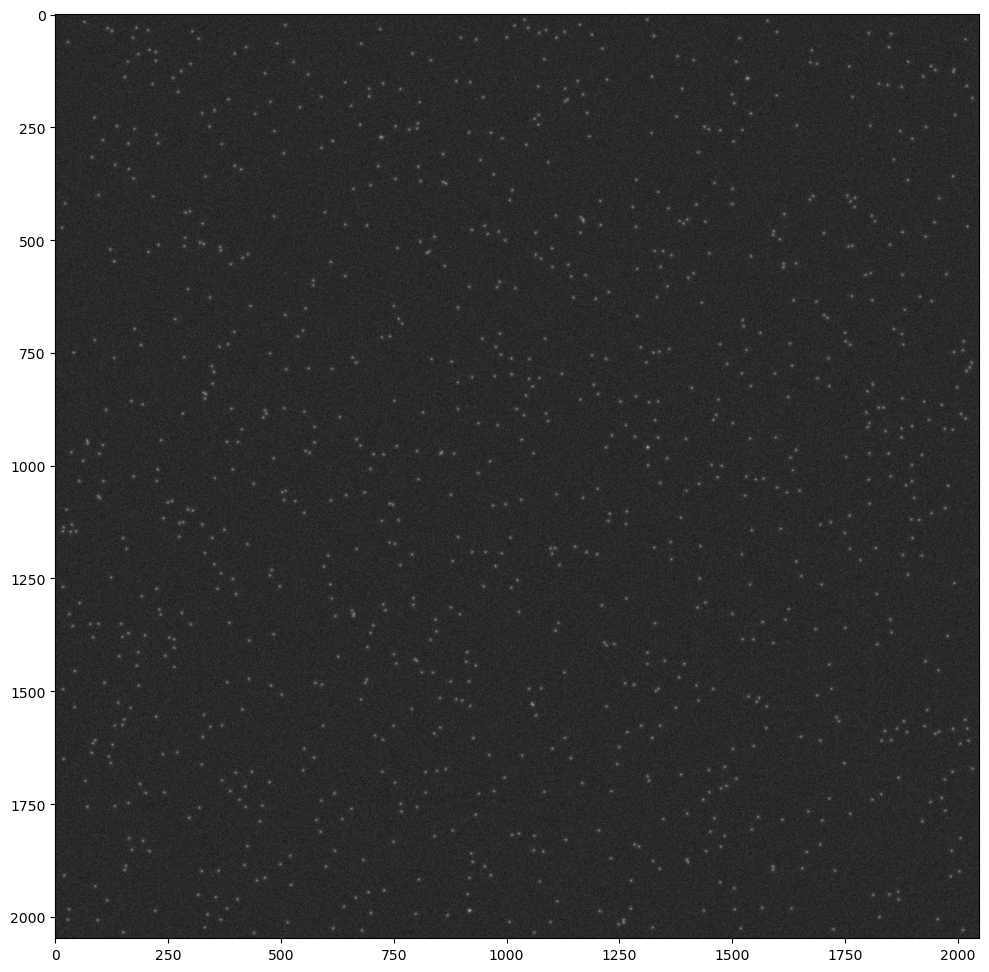

In [6]:
plt.figure(figsize = (12,12))
plt.imshow(hdu_list[1].data, cmap="gray")

This is a simulated image, with uniform sources. Perfectly for our use case: For each source make a cut-out of the image (called a stamp) and then do some processing on this.
A real Euclid image looks quiet differently, like this:
![GPU Basics Slide](img/VIS_exposure.png)
src: https://arxiv.org/pdf/2503.15303

We create a JSON file named **`shuffled_batches.json`**, which stores a dump of a `List[List[int]]`.  
- Each inner list represents a batch of indices to be processed by one process.  
- The data is split into **1000 batches** and then **randomly shuffled**.  

This setup simulates the **worst-case access pattern** for our shared filesystem.

In [9]:
shuffled_ids = np.random.permutation([i for i in range(len(mer_table))])
shuffled_batches = [[int(i) for i in batch] for batch in np.array_split(shuffled_ids, 1000)]
with open("profiling/shuffled_batches.json", "w") as f:
    json.dump(shuffled_batches, f)

#### Task 1  

Create a shell script named **`profiling/stamp_processing_fits_shuffled.sh`**.  
This script should run the following command:

```bash
conda run -n summer-school-hpc-2025 mpirun --use-hwthread-cpus python execute_on_batch.py shuffled fits
```

What this does:

* Launches the stamp extraction step.
* Each MPI rank loads one batch from the shuffled list.
* Only one batch is processed per rank (i.e., not all batches are processed - except if we use 1000 processes).
* For each object ID in the batch, the code creates a galaxy cut-out (stamp).
* No further processing is done on the stamp; instead, the code calls time.sleep(0.5) to simulate computation time.

Important:

* The script will be submitted via sbatch, so you should include appropriate SBATCH directives
* To make mpirun work correctly on the cluster, additional setup is required
* → We will discuss these details together in class.

In [ ]:
%%writefile profiling/stamp_processing_fits_shuffled.sh


Overwriting profiling/stamp_processing_fits_shuffled.sh


In [11]:
!chmod +x profiling/stamp_processing_fits_shuffled.sh

Let's give it a try and execute it on the cluster!

```bash
sbatch --ntasks=2 --output=stamp_fits_shuffled.out profiling/stamp_processing_fits_shuffled.sh
```

In [4]:
!sacct -j 27245126

JobID           JobName  Partition    Account  AllocCPUS      State ExitCode 
------------ ---------- ---------- ---------- ---------- ---------- -------- 
27245126     stamp_pro+    general     merlin          4    RUNNING      0:0 
27245126.ba+      batch                merlin          4    RUNNING      0:0 
27245126.ex+     extern                merlin          4    RUNNING      0:0 


We provide a helper function to visualize profiling results from our runs:  

```python
plot_profiling(
    file_types=["fits", "hdf5"],
    sorting_types=["shuffled", "sorted"],
    prefixes=[""],
    sizes=[1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
)
```
* file_types: select which file formats to include (e.g., "fits", "hdf5")
* sorting_types: choose the access pattern (e.g., "shuffled", "sorted")
* sizes: define the batch sizes or number of ranks to plot

Use these arguments to control which experiments are compared in the plot.

In [33]:
def plot_profiling(file_types=["fits", "hdf5"], sorting_types=["shuffled", "sorted"],
                   prefixes=[""], sizes=[1,2,4,8,16,32,64,128,256,512]):
    fig, axs = plt.subplots(3, 2, figsize=(10, 10))
    fig.suptitle("Profiling stats – mean for a single stamp extraction over time", fontsize=14)
    for file_type in file_types:
        for sorting_type in sorting_types:
            for size in sizes:
                for prefix in prefixes:
                    if os.path.exists(f"profiling/{prefix}profiling_{file_type}_{sorting_type}_{size}.json"):
                        with open(f"profiling/{prefix}profiling_{file_type}_{sorting_type}_{size}.json") as f:
                            json_list = [json.loads(line) for line in f]
                        ticks = [item["tick"] for item in json_list]
                        walltime = [item["walltime"] for item in json_list]
                        axs[0,0].plot(ticks, walltime, marker='o', label=f"{prefix}{file_type}_{sorting_type}_{size}")
                        axs[0,0].set_ylabel("Execution Time [ms]")
                        read_ops = [item["read_ops"] for item in json_list]
                        axs[0,1].plot(ticks, read_ops, marker='o', label=f"{prefix}{file_type}_{sorting_type}_{size}")
                        axs[0,1].set_ylabel("read ops")
                        read_bytes = [item["read"] for item in json_list]
                        axs[1,0].plot(ticks, read_bytes, marker='o', label=f"{prefix}{prefix}{file_type}_{sorting_type}_{size}")
                        axs[1,0].set_ylabel("read [KB]")
                        open_files = [item["open_files"] for item in json_list]
                        axs[1,1].plot(ticks, open_files, marker='o', label=f"{prefix}{file_type}_{sorting_type}_{size}")
                        axs[1,1].set_ylabel("open files [FD]")
                        rss = [item["rss"] for item in json_list]
                        axs[2,0].plot(ticks, rss, marker='o', label=f"{prefix}{file_type}_{sorting_type}_{size}")
                        axs[2,0].set_ylabel("Memory (rss) [MB]")
                        vms = [item["vms"] for item in json_list]
                        axs[2,1].plot(ticks, vms, marker='o', label=f"{prefix}{file_type}_{sorting_type}_{size}")
                        axs[2,1].set_ylabel("Memory (vms) [MB]")

    for ax in axs.flat:
        ax.set_xticks([])  
        ax.set_xlabel("-- time -->")
    
    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=len(labels), bbox_to_anchor=(0.5, 0.96))
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

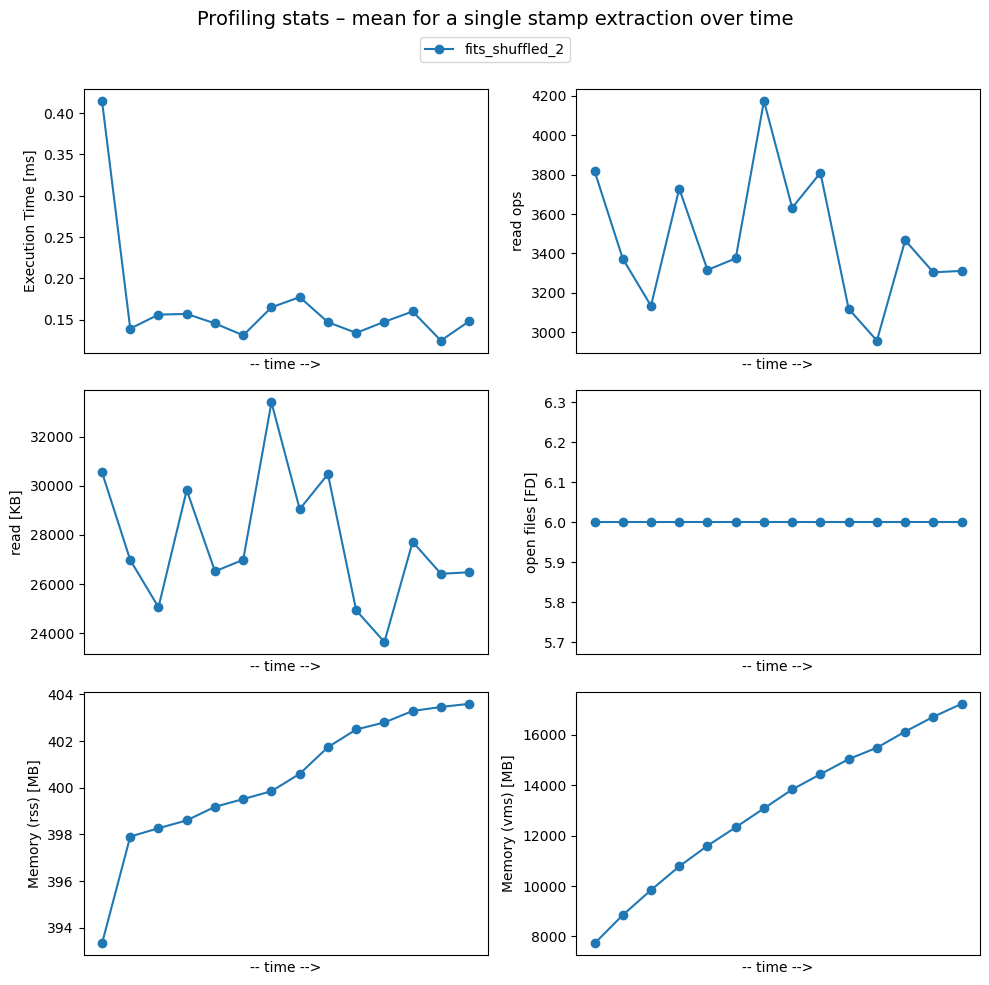

In [34]:
plot_profiling(file_types=["fits"], sorting_types=["shuffled"],sizes=[2])

![FS_Slide](img/HPCP_FS/Folie6.PNG)

#### Task 2  

Modify the experiment to run with **32 processes**.  
- In this case, the **GPFS pagepool cache** will be shared among all processes, increasing contention.  
- On the Merlin 6 nodes, the default pagepool size is **6 GB**.  

Next, repeat the test with **32 processes**, but request the reservation **`sschool25_small`**.  
- These nodes have only **1 GB pagepool**.  

**Question:** Do you observe a significant difference in performance between 6 GB and 1 GB pagepool? Plot the results. You have to rename the coresponding profiling file to 1GB_GPFS_... and 6GB_GPFS_... to be able to use the plot as bellow. 

Hint: `sbatch --ntasks=32 --output=stamp_fits_shuffled.out profiling/stamp_processing_fits_shuffled.sh`

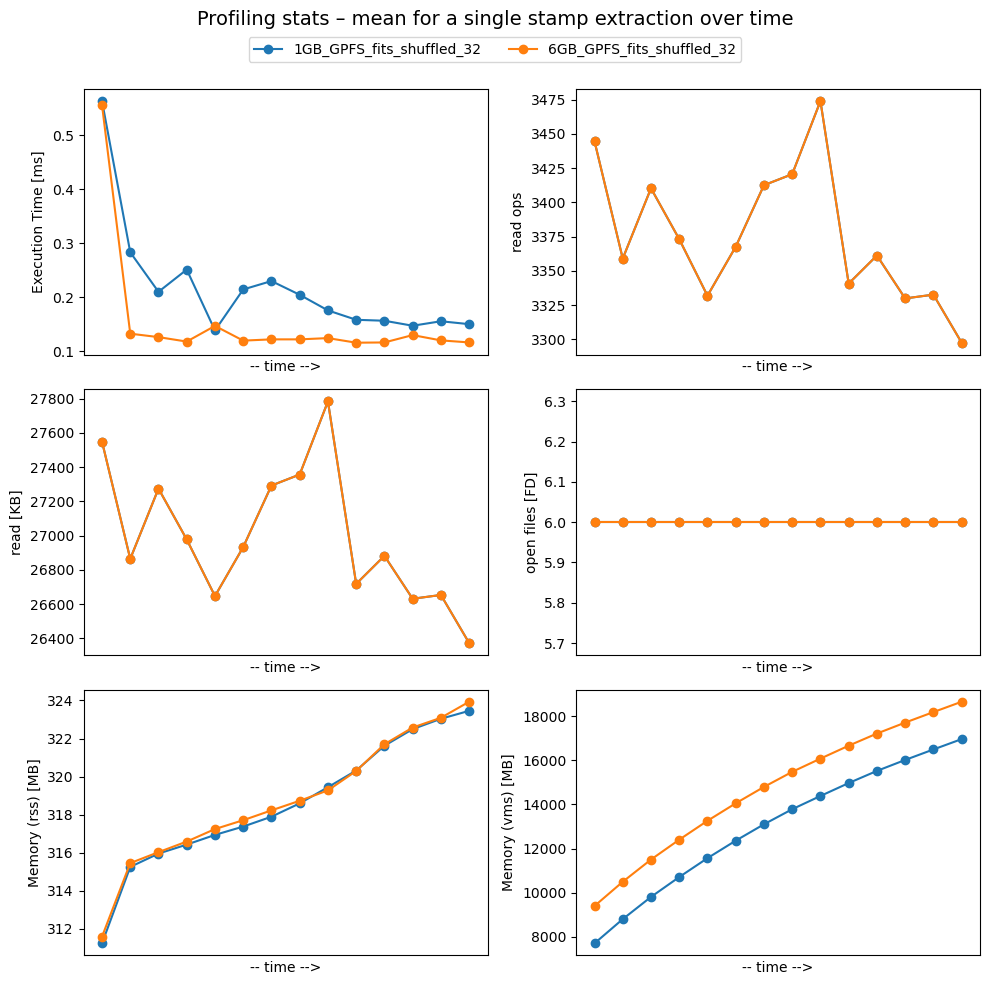

In [35]:
plot_profiling(file_types=["fits"], sorting_types=["shuffled"], sizes=[32], prefixes=["1GB_GPFS_", "6GB_GPFS_"])

#### Task 3  

Increase the number of processes and observe how this affects performance.  
- With multiple nodes accessing the same file concurrently, the **shared filesystem** experiences additional pressure.  
- Run the experiment with **62, 128, 256, and 512 processes**.  

Finally, **plot the results** to visualize the scaling behavior.

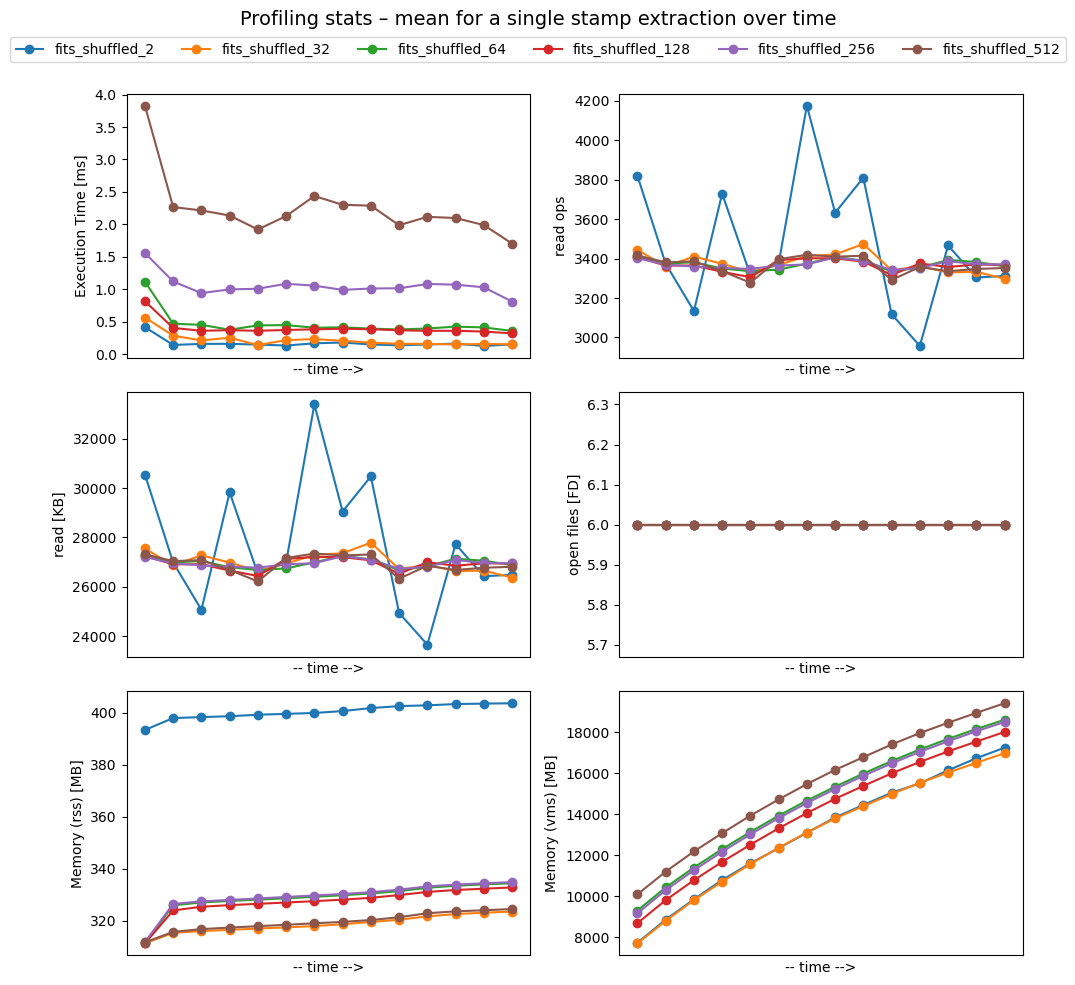

In [39]:
plot_profiling(file_types=["fits"], sorting_types=["shuffled"],sizes=[2,32,64,128,256,512])

We observe that extracting a single stamp takes about **0.1 seconds** when running on a single node.  
With **512 processes**, the time increases to roughly **2.5 seconds per extraction** — a **25× slowdown**!  

Note that 512 processes is not an unusually high number on this cluster (it supports far more), but our goal here is not to bring the entire system to a halt.

![FS_Slide](img/HPCP_FS/Folie7.PNG)

#### Task 4  

Reorder the dataset so that **spatially close objects are grouped together**.  
We can achieve this by building a **KD-Tree**.  

To construct the KD-Tree, first convert **RA** and **DEC** into Cartesian coordinates **(X, Y, Z)** using:  

$$
\begin{aligned}
X &= \cos B \cdot \cos A \\
Y &= \cos B \cdot \sin A \\
Z &= \sin B
\end{aligned}
$$

**Hints:**  
1. Use `np.radians()` to convert RA/DEC into radians before applying the formula.  
2. Build the KD-Tree input as: `xyz = np.asarray([x, y, z]).T` This is the format the KD-Tree expects.

Finally, split the data into 1000 batches and write them to the file: profiling/sorted_batches.json

In [ ]:
#ToDo

with open("profiling/sorted_batches.json", "w") as f:
    json.dump(sorted_batches, f)

#### Task 5

Run experiments using the **sorted batches**.  
Modify the execution command as follows:  

```bash
conda run -n summer-school-hpc-2025 mpirun --use-hwthread-cpus python execute_on_batch.py sorted fits
```

After running the experiments, plot your results and be prepared to discuss your observations in class.

In [41]:
%%writefile profiling/stamp_processing_fits_sorted.sh
#!/bin/bash

#SBATCH --hint=multithread

module load anaconda
cd /psi/home/${USER}/HS25/04_Advanced
export PYTHONPATH=/psi/home/${USER}/HS25/04_Advanced:$PYTHONPATH
conda run -n summer-school-hpc-2025 mpirun --use-hwthread-cpus python stampextraction/execute_on_batch.py sorted fits

Overwriting profiling/stamp_processing_fits_sorted.sh


```bash
sbatch --ntasks=32  --output=stamp_fits_sorted.out profiling/stamp_processing_fits_sorted.sh
```

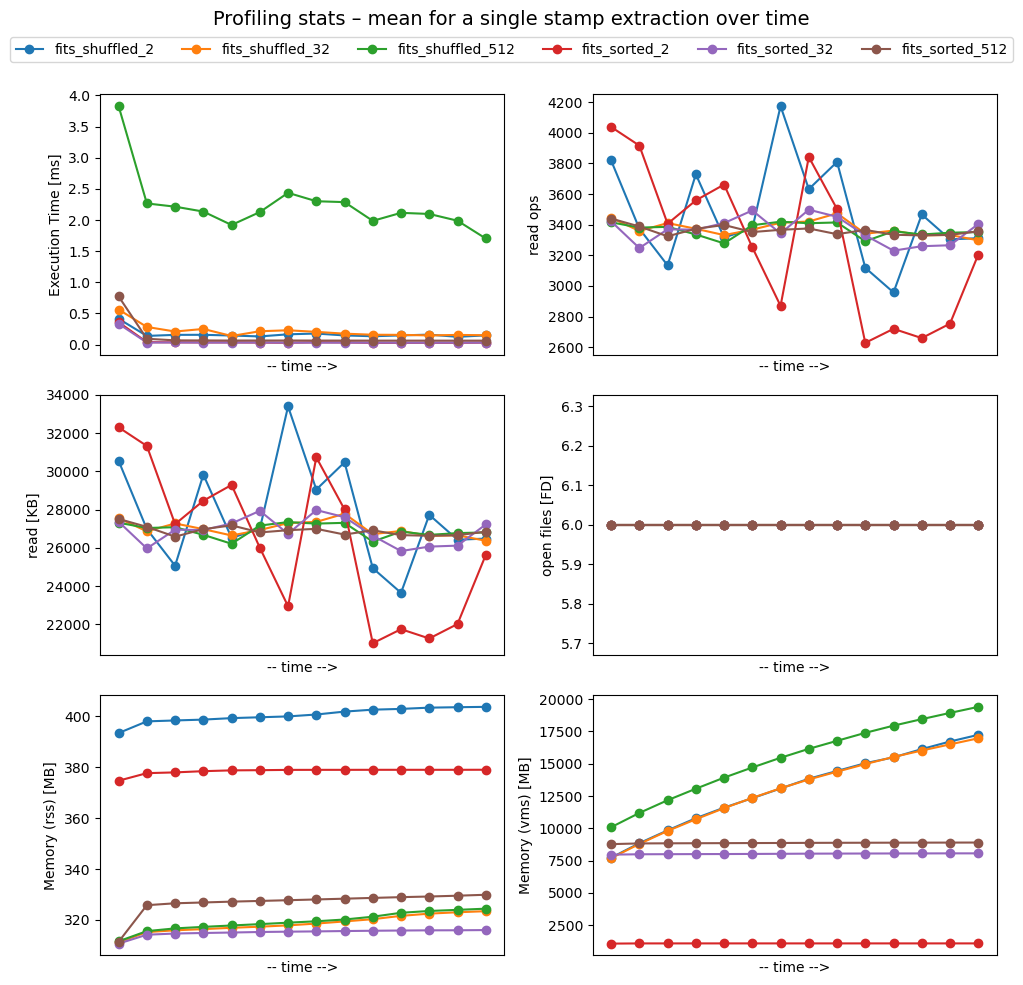

In [43]:
plot_profiling(file_types=["fits"], sorting_types=["shuffled", "sorted"],sizes=[2,32,512])

![FS_Slide](img/HPCP_FS/Folie8.PNG)

#### Task 6

Run experiments using the HDF5 file format. There is already a converted file available.  
Modify the execution command as follows:  

```bash
conda run -n summer-school-hpc-2025 mpirun --use-hwthread-cpus python execute_on_batch.py sorted hdf5
```

After running the experiments, plot your results and be prepared to discuss your observations in class.

In [44]:
%%writefile profiling/stamp_processing_hdf5_sorted.sh
#!/bin/bash

#SBATCH --hint=multithread

module load anaconda
cd /psi/home/${USER}/HS25/04_Advanced
export PYTHONPATH=/psi/home/${USER}/HS25/04_Advanced:$PYTHONPATH
conda run -n summer-school-hpc-2025 mpirun --use-hwthread-cpus python stampextraction/execute_on_batch.py sorted hdf5

Writing profiling/stamp_processing_hdf5_sorted.sh


In [45]:
%%writefile profiling/stamp_processing_hdf5_shuffled.sh
#!/bin/bash

#SBATCH --hint=multithread

module load anaconda
cd /psi/home/${USER}/HS25/04_Advanced
export PYTHONPATH=/psi/home/${USER}/HS25/04_Advanced:$PYTHONPATH
conda run -n summer-school-hpc-2025 mpirun --use-hwthread-cpus python stampextraction/execute_on_batch.py shuffled hdf5

Writing profiling/stamp_processing_hdf5_shuffled.sh


```bash
sbatch --ntasks=2  --output=stamp_hdf5_sorted.out profiling/stamp_processing_hdf5_sorted.sh
sbatch --ntasks=2  --output=stamp_hdf5_sorted.out profiling/stamp_processing_hdf5_shuffled.sh
```

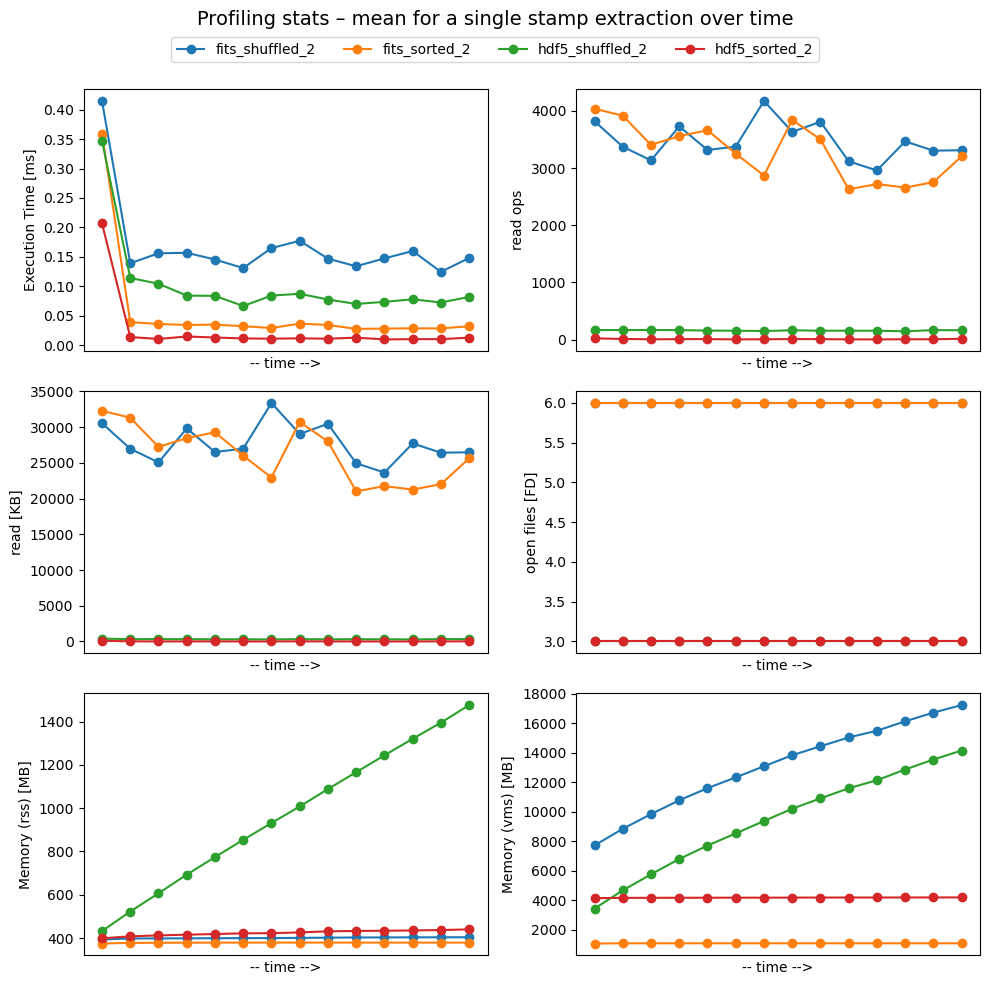

In [47]:
plot_profiling(file_types=["fits", "hdf5"], sorting_types=["shuffled", "sorted"],sizes=[2])

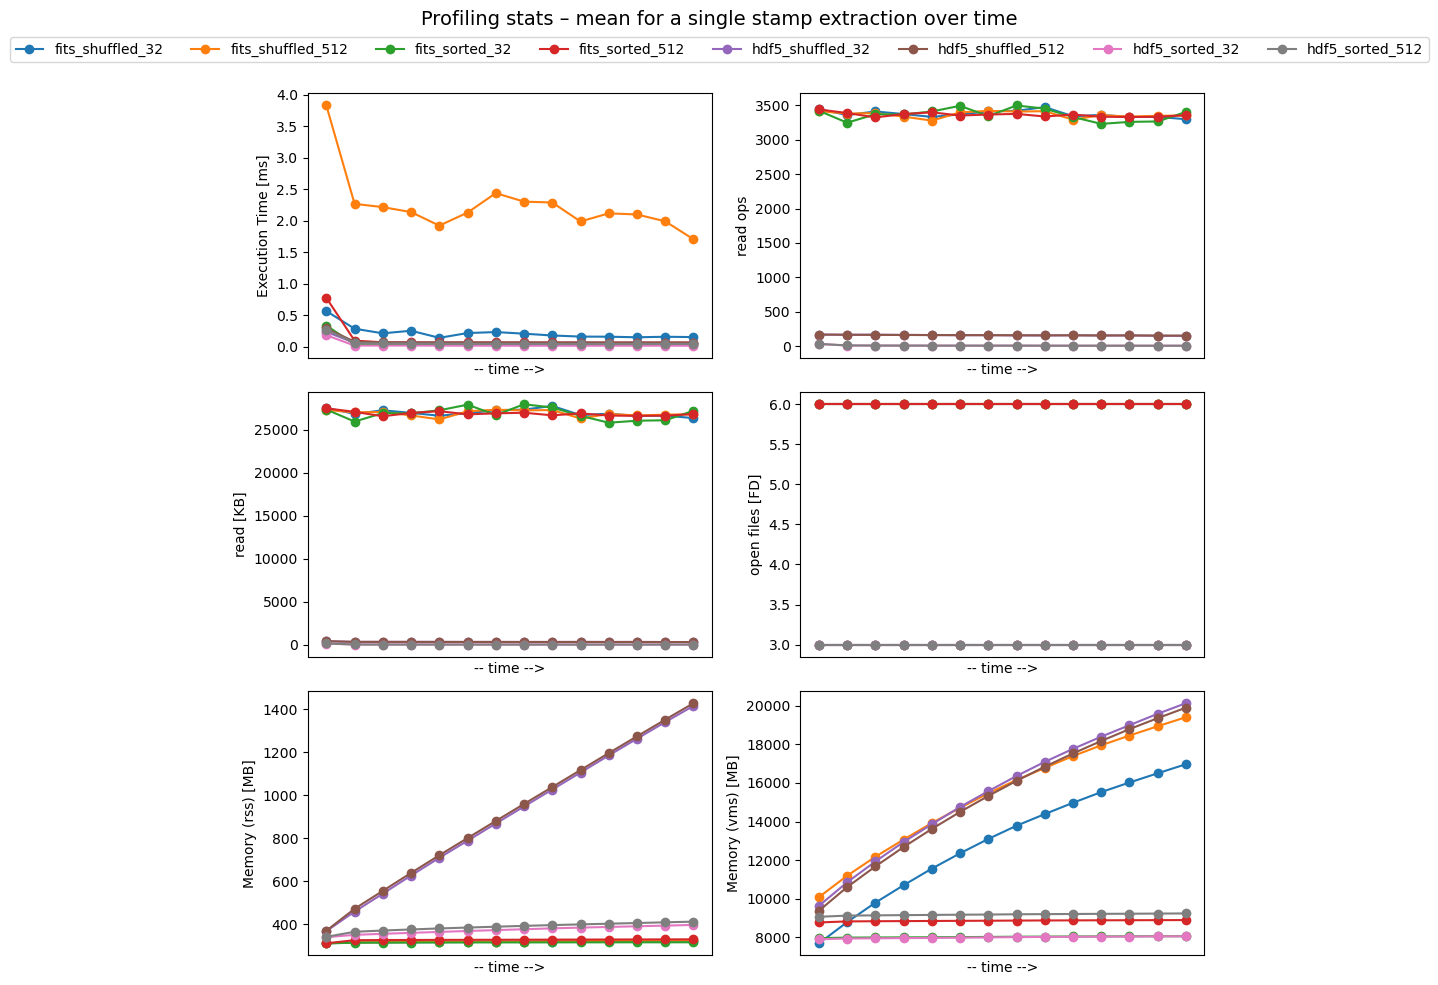

In [48]:
plot_profiling(file_types=["fits", "hdf5"], sorting_types=["shuffled", "sorted"],sizes=[32, 512])

![FS_Slide](img/HPCP_FS/Folie9.PNG)

![FS_Slide](img/HPCP_FS/Folie10.PNG)